<a href="https://www.kaggle.com/code/sheemamasood/birdclef2025-model-training?scriptVersionId=245933993" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🐦 BirdCLEF 2025 - Audio Classification & Sound Event Detection

## 📘 Introduction

This notebook is part of the **BirdCLEF 2025** challenge, which focuses on the **identification of bird species from audio recordings** in natural environments. It is a part of the **LifeCLEF** series organized by the **CLEF (Conference and Labs of the Evaluation Forum)**, and provides a real-world scenario for bioacoustic research and machine learning in the wild.

The main objective of this competition is to build models that can detect the presence of bird species in field recordings — potentially overlapping, noisy, and highly imbalanced — using audio classification and sound event detection (SED) techniques.

---

## 📂 Dataset Overview

The dataset consists of:

- `train_audio/` – Raw training audio files (typically 1-minute recordings).
- `train_metadata.csv` – Contains metadata for each audio file such as species label, rating, and location.
- `train_soundscapes/` and `test_soundscapes/` – Simulated soundscape audio segments for evaluation.
- `taxonomy.csv` – A hierarchy of species, genus, and family for all classes in the dataset.

---
### Data Preparation & Mel Generation

Before training this model, the dataset was carefully prepared using the following steps:

- **Data Preparation Notebook:**  
  [BirdCLEF 2025 Data Preparation](https://www.kaggle.com/code/sheemamasood/birdclef-2025-data-prepartion)  
  - Created 10-second audio chunks from both train and soundscape recordings  
  - Applied VAD (Voice Activity Detection) filtering to remove unwanted noise and silence  
  - Built a clean, balanced dataset ready for feature extraction and training

- **Mel Spectrogram Generation Notebook:**  
  [BirdCLEF2025 Mel Generation](https://www.kaggle.com/code/sheemamasood/birdclef2025-mel-generation)  
  - Converted audio chunks into mel spectrograms  
  - Saved mel spectrograms as inputs for model training  

These preprocessing steps ensure the model receives high-quality, meaningful inputs, improving training effectiveness and overall performance.
************

## ⚙️ Preprocessing Pipeline

In this notebook, we focus on:

- Creating a **custom PyTorch Dataset class** to efficiently load and manage training samples.
- Loading **preprocessed metadata** (filtered by rating, etc.) and **precomputed mel spectrograms** for fast training.
- Preparing inputs to be used directly in model training or evaluation.

We have saved the mel spectrograms in `.npz` format for efficient access, reducing the on-the-fly computation cost during model training.

---

Let's begin! 🚀


## 🔗 BirdCLEF 2025 - Project Notebook Links

Here are the different stages of my BirdCLEF 2025 pipeline, organized by functionality:

### 📊 Data Preparation
- [BirdCLEF 2025 - Data Preparation](https://www.kaggle.com/code/sheemamasood/birdclef-2025-data-prepartion)

### 🎛️ Mel Spectrogram Generation
- [BirdCLEF 2025 - Mel Generation](https://www.kaggle.com/code/sheemamasood/birdclef2025-mel-generation)

### 🏷️ Pseudo Labelling for SSL
- [BirdCLEF 2025 - Pseudo Labelling for SSL](https://www.kaggle.com/code/sheemamasood/birdclef2025-psedolabelling-for-ssl)

### 🧠 Model Training
- [BirdCLEF 2025 - Model Training (Phase 1)](https://www.kaggle.com/code/sheemamasood/birdclef2025-model-training-phase1)

### 📦 Inference & Submissions
- [BirdCLEF 2025 - Submissions](https://www.kaggle.com/code/sheemamasood/birdclef2025-submissions)


In [1]:
# Standard Libraries
import os
import gc
import time
import math
import random
import warnings
import logging
from pathlib import Path
from glob import glob
from typing import Union
import copy
import concurrent.futures

# Data Handling
import numpy as np
import pandas as pd
import joblib
import pickle
import collections
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report

# Audio Processing
import librosa
import librosa.display
import soundfile as sf
from soundfile import SoundFile
import torchaudio

# Machine Learning & PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.cuda.amp import autocast, GradScaler
import timm

# Visualization
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Progress Bars
from tqdm import tqdm
from tqdm.notebook import tqdm as notebook_tqdm

# Logging and Warnings
warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.ERROR)

# Check versions
print(f"librosa version : {librosa.__version__}")
print(f"librosa files : {librosa.__file__}")
print("✅ All libraries imported in the environment.")


librosa version : 0.11.0
librosa files : /usr/local/lib/python3.11/dist-packages/librosa/__init__.py
✅ All libraries imported in the environment.


In [2]:

class Config:
    # ===== General Settings =====
    seed = 42
    print_freq = 100
    num_workers = 4

    # ===== Audio Settings =====
    FS = 32000  # Sampling rate
    N_FFT = 1024
    HOP_LENGTH = 512
    FMIN = 50
    FMAX = 14000
    N_MELS = 128
    TARGET_DURATION = 10.0  # duration in seconds for full input
    TARGET_DURATION_TRAIN = 10
    TARGET_DURATION_TEST = 5

    # ===== Image / Mel Spectrogram Settings =====
    MEL_SHAPE = (256, 256)         # (height, width)
    TARGET_SHAPE = (3, 256, 256)   # RGB Image Shape (C, H, W)

    
    # ===== File Paths =====
    test_soundscapes = "/kaggle/input/birdclef-2025/test_soundscapes"
    submission_csv = "/kaggle/input/birdclef-2025/sample_submission.csv"
    model_path = "/kaggle/input/birdcleft-clean-and-vad-filtered-data/best_model_187.pth"
    backbone_weights = "/kaggle/input/birdcleft-clean-and-vad-filtered-data/seresnext_backbone_weights.pth"
    master_labels = "/kaggle/input/birdcleft-clean-and-vad-filtered-data/valid_labels.pkl"

    # ===== Model Settings =====
    model_name = 'seresnext26t_32x4d'
    pretrained = False
    in_channels = 1

    # ===== Derived Attributes (initialized later) =====
    master_labels = None
    NUM_CLASSES = None


# Instantiate and initialize
config = Config()

print(f"✅ Loaded master label list. Total number of classes: {config.NUM_CLASSES}")
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
species_ids = pd.read_csv(config.submission_csv).columns[1:].tolist()

✅ Loaded master label list. Total number of classes: None


## 🏷️ Master Label List (After Cleaning and VAD Filtering)

To ensure training on high-quality and relevant audio data, we applied:

- ✅ **Voice Activity Detection (VAD) filtering** to remove silent and noisy segments.
- 🧹 **Data cleaning** to exclude low-rated or irrelevant samples.
- 🔁 **Chunking** of longer audio files into fixed-duration segments (e.g., 5s or 10s).

After these preprocessing steps, we extracted a list of **valid bird species labels** that are actually present in the cleaned dataset. This label list will serve as our **master label set**, which defines the total number of output classes for our model.

We loaded this list from the file `valid_labels.pkl`:


In [3]:
# Load the master label list and set NUM_CLASSES
with open("/kaggle/input/birdcleft-clean-and-vad-filtered-data/valid_labels.pkl", "rb") as f:
    master_labels = pickle.load(f)
NUM_CLASSES = len(master_labels)  # should be 206


print(f"total number of labels in full data : {len(master_labels)}")  # Should print 206

total number of labels in full data : 187


In [4]:
def set_seed(seed=42):
    """
    Set seed for reproducibility
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(config.seed)


## 📥 Loading Clean Mel Spectrogram Data

We use a **cleaned and VAD-filtered CSV file** that contains metadata for high-quality audio chunks (10-second segments). Corresponding **precomputed mel spectrograms** are stored in `.npz` format for fast and efficient access during training.

Only files prefixed with `clean_train` are loaded to ensure that we are working strictly with clean training data. We then build an **index mapping from each spectrogram key to its `.npz` file**, allowing us to quickly locate and load the correct mel data for any given audio chunk.

This setup enables:
- ⚡ Fast data loading during training  
- 🧠 Memory-efficient batch management  
- ✅ Guaranteed alignment between metadata and audio features  


In [5]:
# Your input directory
mel_dir = "/kaggle/input/birdclef-2025-mel-spectrogram"
csv_path = "/kaggle/input/birdcleft-clean-and-vad-filtered-data/train_audio_10sec_chunks_VAD_filtered.csv"

# Read only clean train dataframe
clean_train_df = pd.read_csv(csv_path)
print("✅ CSV loaded:", clean_train_df.shape)

# Filter only clean_train mel batches
clean_train_files = sorted([
    f for f in os.listdir(mel_dir)
    if f.startswith("clean_train") and f.endswith(".npz")
])
print(f"🟢 Found {len(clean_train_files)} clean_train .npz files")

# Build key-to-file index for clean_train only
key_to_file = {}

print("🔍 Indexing clean_train mel keys...")
for batch_file in tqdm(clean_train_files):
    path = os.path.join(mel_dir, batch_file)
    try:
        npz = np.load(path)
        for key in npz.files:
            key_to_file[key] = batch_file
    except Exception as e:
        print(f"⚠️ Error reading {batch_file}: {e}")

print(f"✅ Total keys indexed: {len(key_to_file)}")


✅ CSV loaded: (47342, 15)
🟢 Found 48 clean_train .npz files
🔍 Indexing clean_train mel keys...


100%|██████████| 48/48 [00:01<00:00, 34.94it/s]

✅ Total keys indexed: 47342


In [6]:
# Master label filtering before any split
#label_counts = clean_train_df['primary_label'].value_counts()
#valid_labels = label_counts[label_counts >= 2].index



#with open("valid_labels.pkl", "wb") as f:
    #pickle.dump(valid_labels.tolist(), f)
# i have saved it once and then we will be loading it directly in dataset class

## ✅ Sanity Check: Load and Inspect Sample Mel Spectrograms

To verify that the precomputed mel spectrograms are loading correctly, we randomly selected a few `chunk_id`s from the clean training data and inspected their:

- ✅ Shape
- 📊 Min, Max, and Mean values

This helps ensure that:
- All chunks are correctly indexed
- Mel arrays are in expected format and range
- There are no corrupted or missing keys in our `.npz` files


In [7]:
# Pick 3 random chunk_ids from the clean train CSV
sample_keys = random.sample(clean_train_df['chunk_id'].tolist(), 3)

def load_clean_train_mel(chunk_id):
    if chunk_id not in key_to_file:
        raise ValueError(f"❌ Key {chunk_id} not found.")
    file = key_to_file[chunk_id]
    path = os.path.join(mel_dir, file)
    with np.load(path) as npz:
        return npz[chunk_id]

for key in sample_keys:
    mel = load_clean_train_mel(key)
    print(f"\nChunk ID: {key}")
    print(f"Shape: {mel.shape}")
    print(f"Min: {mel.min():.4f}, Max: {mel.max():.4f}, Mean: {mel.mean():.4f}")



Chunk ID: whtdov-XC716476_chunk3
Shape: (3, 256, 256)
Min: 12.0000, Max: 248.0000, Mean: 124.8942

Chunk ID: bobfly1-XC214584_chunk2
Shape: (3, 256, 256)
Min: 28.0000, Max: 247.0000, Mean: 163.7904

Chunk ID: 715170-CSA35802_chunk2
Shape: (3, 256, 256)
Min: 25.0000, Max: 254.0000, Mean: 97.2579


## 🎛️ Custom Dataset: `BirdMelNPZDataset`

This class defines a PyTorch-compatible dataset that handles:

- 📦 Loading precomputed **mel spectrograms** (saved in `.npz` files)
- 🧠 Mapping each `chunk_id` to its corresponding spectrogram
- 🏷️ Encoding **primary and secondary labels** as multi-hot vectors
- 🔁 Optionally applying **data augmentation** (time/frequency masking, noise)

### 🔍 Key Features:
- ✅ Uses an indexed dictionary `key_to_file` to locate each spectrogram efficiently
- 🧊 Caches `.npz` files per batch to reduce repeated disk reads
- 🪄 Applies **on-the-fly audio-level augmentations** during training if `augment=True`
- 🎯 Supports **multi-label targets** using both primary and secondary labels

This modular and efficient dataset class makes it easy to plug into a `DataLoader` and ensures high performance during training and validation.


In [8]:
class BirdMelNPZDataset(Dataset):
    def __init__(self, df, mel_dir, key_to_file, labels=None, augment=False, sample_rate=32000):
        self.df = df.reset_index(drop=True)
        self.mel_dir = mel_dir
        self.key_to_file = key_to_file
        self.augment = augment
        self.sample_rate = sample_rate

        if labels is None:
            with open("/kaggle/input/birdcleft-clean-and-vad-filtered-data/valid_labels.pkl", "rb") as f:
                self.labels = pickle.load(f)
        else:
            self.labels = labels

        self.label2idx = {label: idx for idx, label in enumerate(self.labels)}
        self.num_classes = len(self.labels)

        self.df['chunk_id_clean'] = self.df['chunk_id'].str.replace('/', '-', regex=False)

        # Cache loaded npz files to avoid multiple reloads in an epoch
        self.loaded_batches = {}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        key = row['chunk_id_clean']

        batch_file = self.key_to_file.get(key, None)
        if batch_file is None:
            # Key not found in index
            mel = np.zeros((3, 256, 256), dtype=np.float32)  # assuming shape
        else:
            # Load batch file if not already loaded
            if batch_file not in self.loaded_batches:
                path = os.path.join(self.mel_dir, batch_file)
                self.loaded_batches[batch_file] = np.load(path)

            mel = self.loaded_batches[batch_file][key]

        if self.augment:
            mel = self.apply_augmentation(mel)

        mel_tensor = torch.tensor(mel, dtype=torch.float32)  # (3, 256, 256)

        label_vec = np.zeros(self.num_classes, dtype=np.float32)
        label_vec[self.label2idx[row['primary_label']]] = 1.0

        # Handling secondary labels if present
        if 'secondary_labels' in row and isinstance(row['secondary_labels'], list):
            for sec in row['secondary_labels']:
                if sec in self.label2idx:
                    label_vec[self.label2idx[sec]] = 1.0

        return mel_tensor, torch.tensor(label_vec)

    # (Augmentation methods )


    def apply_augmentation(self, mel):
        mel = self.time_mask(mel, T=30)
        mel = self.freq_mask(mel, F=15)
        mel = self.add_noise(mel, noise_level=0.01)
        return mel

    def time_mask(self, mel, T=30):
        t = mel.shape[2]  # time dimension
        t0 = np.random.randint(0, max(1, t - T))
        mel[:, :, t0:t0 + T] = 0
        return mel

    def freq_mask(self, mel, F=15):
        f = mel.shape[1]  # frequency dimension
        f0 = np.random.randint(0, max(1, f - F))
        mel[:, f0:f0 + F, :] = 0
        return mel

    def add_noise(self, mel, noise_level=0.01):
        noise = np.random.randn(*mel.shape) * noise_level
        return mel + noise




## 🧩 Collate Function: `collate_pad_mel`

This custom collate function ensures all mel spectrograms in a batch have the **same time dimension** by:

- 🔍 Finding the max time length in the batch
- 🧱 Padding shorter spectrograms on the time axis using `torch.nn.functional.pad`
- 📦 Stacking padded tensors into a batch of shape `(B, C, n_mels, max_time)`

This is essential when working with variable-length audio chunks to enable smooth batching in PyTorch `DataLoader`.


In [9]:
# collate function to pad mel spectrograms on time dimension (if varying length)
def collate_pad_mel(batch):
    mel_specs = [item[0] for item in batch]  # each shape (C, n_mels, time)
    targets = [item[1] for item in batch]

    max_time = max([m.shape[-1] for m in mel_specs])

    padded_mels = []
    for m in mel_specs:
        pad_len = max_time - m.shape[-1]
        padded = F.pad(m, (0, pad_len))
        padded_mels.append(padded)

    mel_specs_padded = torch.stack(padded_mels)  # (B, C, n_mels, max_time)
    targets = torch.stack(targets)

    return mel_specs_padded, targets


## ⚖️ Balanced Sampling: `get_balanced_sampler`

To address class imbalance during training, we use a **`WeightedRandomSampler`**, which ensures that underrepresented classes are sampled more frequently.

### 🔧 How it works:
- 📊 Calculates class frequencies from the `primary_label` column
- 🧮 Assigns **inverse-frequency weights** to each sample
- 🎲 Uses `WeightedRandomSampler` to draw samples with replacement based on these weights

This helps create more balanced mini-batches during training and improves model performance on rare classes.


In [10]:
def get_balanced_sampler(df, label_col='primary_label'):
    """
    Create a WeightedRandomSampler to balance class frequencies.

    Args:
        df: pandas DataFrame with a 'primary_label' column
        label_col: name of the column containing class labels

    Returns:
        torch.utils.data.WeightedRandomSampler
    """
    # Count samples per class
    class_counts = df[label_col].value_counts()
    class_weights = 1. / class_counts

    # Assign each sample its weight
    sample_weights = df[label_col].map(class_weights).values
    sample_weights = torch.tensor(sample_weights, dtype=torch.float32)

    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    return sampler

## 🧪 Train/Validation Split & DataLoader Setup

We prepare the final dataset and dataloaders as follows:

### 🧹 Filter Rare Classes:
- Removed any `primary_label` classes that have **fewer than 2 samples** to avoid training instability.

### 🔀 Stratified Split:
- Used **stratified sampling** to split `clean_train_df` into **80% training** and **20% validation** while preserving class distribution.

### 🧺 Dataset Construction:
- Created two instances of `BirdMelNPZDataset`:
  - `train_dataset` with **on-the-fly augmentation**
  - `val_dataset` without augmentation

### ⚖️ Balanced Sampling:
- For training, used a **`WeightedRandomSampler`** to balance class representation per mini-batch.

### 🚚 Dataloader Initialization:
- Created `train_loader` and `val_loader` using PyTorch `DataLoader` with:
  - `batch_size = 32`
  - `collate_pad_mel()` to pad mel spectrograms
  - `train_loader` uses balanced sampler
  - `val_loader` shuffles disabled for evaluation consistency

### ✅ Dataset Sanity Check:
Printed a few sample entries from the train and validation datasets to ensure:
- Mel spectrogram shapes are correct
- Label vectors are properly one-hot/multi-hot encoded


In [11]:
# Count instances per class
label_counts = clean_train_df['primary_label'].value_counts()

# Keep only those classes with at least 2 samples
valid_labels = label_counts[label_counts >= 2].index
clean_train_df= clean_train_df[clean_train_df['primary_label'].isin(valid_labels)].reset_index(drop=True)
valid_labels.nunique()

187

In [12]:
# Assume mel_dir and key_to_file already defined as:
mel_dir = "/kaggle/input/birdclef-2025-mel-spectrogram"

# Split dataframe into train and validation stratified on primary_label
train_idx, val_idx = train_test_split(
    range(len(clean_train_df)),
    test_size=0.2,
    stratify=clean_train_df['primary_label'],
    random_state=42
)

train_df = clean_train_df.iloc[train_idx].reset_index(drop=True)
val_df = clean_train_df.iloc[val_idx].reset_index(drop=True)

#alag alag datset create 
train_dataset = BirdMelNPZDataset(
    train_df,
    mel_dir=mel_dir,
    key_to_file=key_to_file,
    augment=True  # Enable augmentations in training
)

val_dataset = BirdMelNPZDataset(
    val_df,
    mel_dir=mel_dir,
    key_to_file=key_to_file,
    augment=False
)

# 🔄 Balanced Sampler for training (if you have implemented `get_balanced_sampler`)
train_sampler = get_balanced_sampler(train_df, label_col='primary_label')

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    sampler=train_sampler,
    collate_fn=collate_pad_mel
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_pad_mel
)

def check_dataset(dataset, name="Dataset"):
    mel_tensor,  label_tensor = dataset[0]
    print(f"=== {name.upper()} ===")
    print(f"Mel Spectrogram shape: {mel_tensor.shape}")         # Expected: (128, Time)
    #print(f"YAMNet Embedding shape: {embedding_tensor.shape}")  # Expected: (1024,)
    print(f"Label shape: {label_tensor.shape}")                 # Expected: (206,)

# Check train dataset
check_dataset(train_dataset, "Train Dataset")

sample_idx = 0  # koi b sample index

# Train dataset ka sample
print("=== TRAIN DATASET SAMPLE ===")
print(type(train_dataset))
print(train_dataset[sample_idx])

# Validation dataset ka sample
print("=== VALIDATION DATASET SAMPLE ===")
print(type(val_dataset))
print(val_dataset[sample_idx])



=== TRAIN DATASET ===
Mel Spectrogram shape: torch.Size([3, 256, 256])
Label shape: torch.Size([187])
=== TRAIN DATASET SAMPLE ===
<class '__main__.BirdMelNPZDataset'>
(tensor([[[143.0062, 139.9903, 150.0003,  ..., 143.0026, 140.9955, 141.0128],
         [136.9873, 138.9944, 149.0135,  ..., 145.0034, 143.0111, 142.9946],
         [127.0138, 136.0034, 148.9827,  ..., 149.9874, 147.9954, 147.9970],
         ...,
         [115.9991, 117.0088, 115.0184,  ..., 115.9987, 120.0102, 130.0163],
         [113.9977, 118.0060, 115.0061,  ..., 111.9874, 115.9815, 127.0026],
         [112.9997, 118.0006, 115.0214,  ..., 110.0202, 114.0103, 125.0093]],

        [[142.9888, 140.0094, 149.9916,  ..., 142.9953, 140.9975, 140.9845],
         [136.9909, 138.9881, 149.0079,  ..., 144.9864, 143.0112, 143.0040],
         [126.9828, 136.0061, 149.0057,  ..., 149.9997, 148.0023, 148.0047],
         ...,
         [115.9871, 117.0080, 115.0072,  ..., 115.9950, 120.0036, 129.9866],
         [114.0009, 117.9900, 1

## 📊 Visualizing Mel Spectrograms

To better understand our training data, we define a helper function `plot_multiple_mels` to visualize multiple mel spectrograms side-by-side.

### 🔍 What it does:
- Plots mel spectrograms from given sample indices
- Uses only the **first channel** of each mel tensor
- Adds time and frequency axis labels for clarity
- Automatically includes a colorbar for reference

This is useful for verifying the quality, shape, and content of mel spectrograms before training.

### 🖼️ Example Outputs:
Below we plot 5 random samples from both the training and validation datasets to visually inspect the spectrograms.


Train Samples:


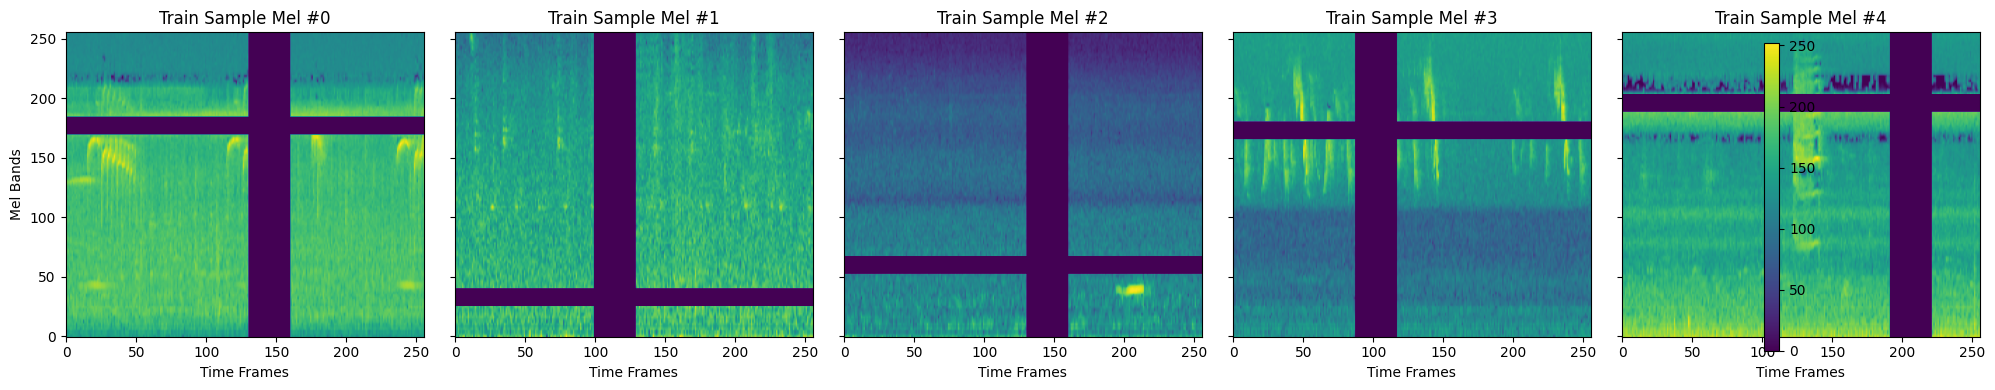

Validation Samples:


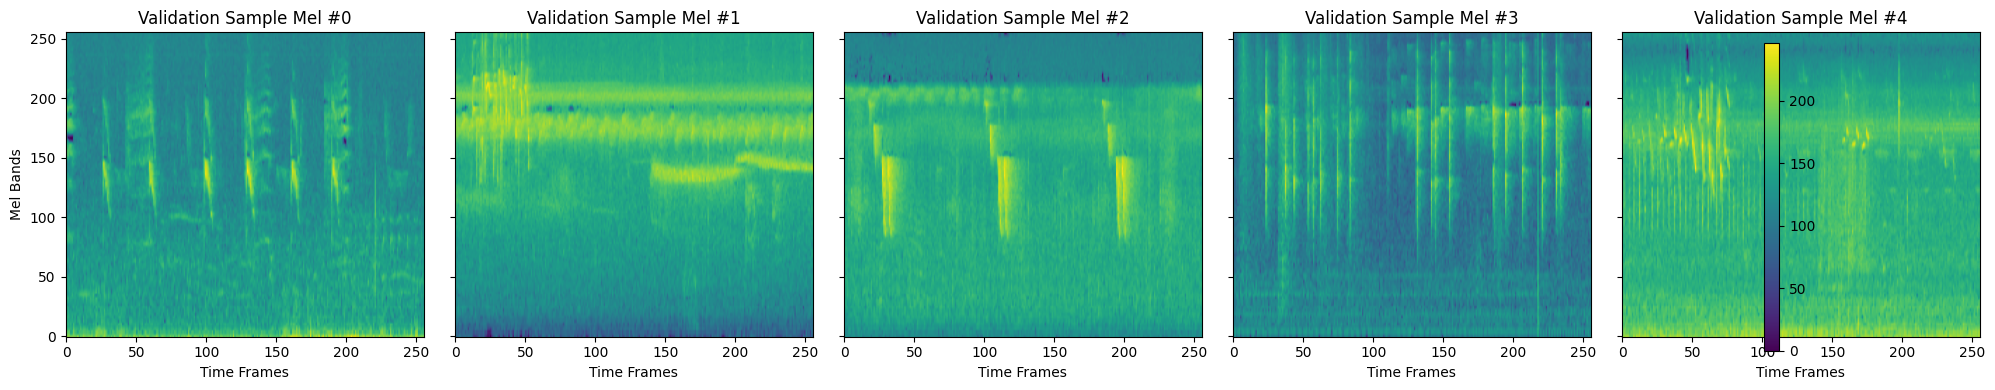

In [13]:
def plot_multiple_mels(dataset, indices, title_prefix='Sample Mel Spectrogram'):
    n = len(indices)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))  # 1 row, n columns

    for i, idx in enumerate(indices):
        mel_tensor, _ = dataset[idx]
        mel = mel_tensor[0].numpy()  # first channel

        ax = axes[i] if n > 1 else axes
        im = ax.imshow(mel, aspect='auto', origin='lower')
        ax.set_title(f"{title_prefix} #{idx}")
        ax.set_xlabel("Time Frames")
        ax.set_ylabel("Mel Bands")
        ax.label_outer()  # Only show outer labels for clean look

    fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    plt.tight_layout()
    plt.show()

# Example usage:
print("Train Samples:")
plot_multiple_mels(train_dataset, indices=list(range(5)), title_prefix='Train Sample Mel')

print("Validation Samples:")
plot_multiple_mels(val_dataset, indices=list(range(5)), title_prefix='Validation Sample Mel')


## 🎲 Sampling Analysis with Balanced Sampler ( uper humny sampler bnaya tha yahan bus use kr k check kry gy)

To verify that the `WeightedRandomSampler` balances the training data, we:

- Print the number of unique labels and sampler length
- Show sample weights of the first 10 samples (inverse frequency weights)
- Collect labels sampled during the first 50 batches from the `train_loader`
- Count and visualize the class distribution of these sampled labels

### 📈 Observation:
The WeightedRandomSampler successfully balances training data by assigning higher sampling weights to rare classes and lower weights to frequent ones. The sampled class distribution over the first 50 batches shows roughly equal representation across classes, improving the model's ability to learn from minority classes and reducing bias toward majority classes.

Unique labels: 187
Sampler length: 37872
First 10 sample weights: [0.0016207455191761255, 0.004854368977248669, 0.001461988314986229, 0.002207505516707897, 0.0015479875728487968, 0.0015600624028593302, 0.01315789483487606, 0.0038314175326377153, 0.0010471204295754433, 0.0019455252913758159]
Sampled class distribution in first 50 batches: Counter({30: 16, 64: 16, 84: 16, 141: 16, 17: 15, 134: 15, 31: 15, 48: 15, 76: 15, 52: 15, 71: 15, 159: 15, 54: 14, 87: 14, 139: 14, 96: 14, 137: 13, 65: 13, 93: 13, 164: 13, 94: 13, 79: 13, 151: 13, 2: 13, 36: 13, 23: 13, 182: 13, 51: 13, 59: 12, 106: 12, 49: 12, 73: 12, 119: 12, 169: 12, 60: 11, 157: 11, 165: 11, 77: 11, 57: 11, 161: 11, 4: 11, 178: 11, 126: 11, 147: 11, 149: 11, 101: 11, 107: 11, 68: 11, 153: 11, 78: 11, 140: 10, 75: 10, 133: 10, 80: 10, 38: 10, 85: 10, 115: 10, 184: 10, 46: 10, 155: 10, 11: 10, 28: 10, 32: 10, 168: 10, 6: 10, 53: 10, 103: 10, 186: 10, 128: 10, 25: 10, 21: 10, 121: 9, 33: 9, 26: 9, 35: 9, 122: 9, 163: 9, 118: 9, 1: 

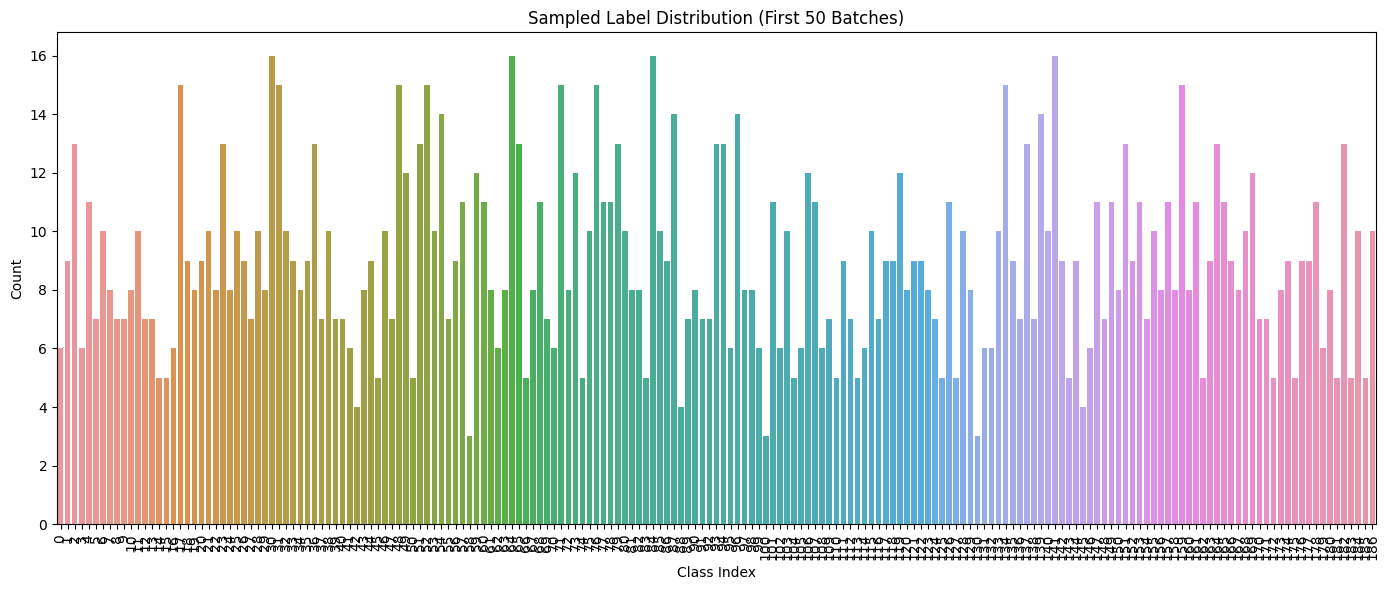

In [14]:
sampler = get_balanced_sampler(train_df)

print("Unique labels:", train_df['primary_label'].nunique())
print("Sampler length:", len(sampler))
sample_weights = [sampler.weights[i].item() for i in range(10)]
print("First 10 sample weights:", sample_weights)

sampled_labels = []
for i, (mels, labels) in enumerate(train_loader):
    sampled_labels.extend(labels.argmax(dim=1).tolist())  # One-hot to class index
    if i > 50:  # Analyze only first 50 batches
        break

print("Sampled class distribution in first 50 batches:", collections.Counter(sampled_labels))
label_counts = dict(collections.Counter(sampled_labels))

plt.figure(figsize=(14, 6))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.title("Sampled Label Distribution (First 50 Batches)")
plt.xlabel("Class Index")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## 🦜 Improved BirdCLEF Model Architecture

We utilize a powerful pretrained backbone from the `timm` library:

- **Backbone:** `seresnext26t_32x4d` pretrained on ImageNet-1k
  - Accepts 3-channel mel spectrogram inputs
  - Outputs a 2048-dimensional feature vector (no classification head)

- **Classifier Head:**
  - Fully connected layer reducing 2048 → 512 features
  - Batch normalization + ReLU activation + dropout (0.3)
  - Final linear layer projecting 512 → number of bird classes (default 187)

This design helps in fine-tuning a strong feature extractor while training a task-specific classifier.

---

## 🧊 Backbone Freezing & Unfreezing Functions

To control training dynamics and speed up convergence:

- `freeze_backbone(model)`: Freeze all backbone layers to train only the classifier head initially.
- `unfreeze_last_blocks(model, num_blocks=2)`: Unfreeze the last few backbone blocks to fine-tune deeper features gradually.

This gradual unfreezing is useful to avoid catastrophic forgetting and improve performance.


In [15]:
#model download kr k weights save kr lety hain (inference me intenet allowed nhi hai to it would be helpful that time)
#model = timm.create_model(
#    "hf_hub:timm/seresnext26t_32x4d.bt_in1k",
#    pretrained=True,
#    in_chans=3,
#    num_classes=0)

# Save the backbone weights locally
#torch.save(model.state_dict(), "seresnext_backbone_weights.pth")


In [16]:
class ImprovedBirdCLEFModel(nn.Module):
    def __init__(self, num_classes=187, pretrained=True):
        super().__init__()
        
        self.backbone = timm.create_model(
            "seresnext26t_32x4d",  # ⬅️ hf_hub hata diya downloaded weights use kry gy
            pretrained=False,  
            in_chans=3,
            num_classes=0
        )

        if pretrained:
            state_dict = torch.load("/kaggle/input/birdcleft-clean-and-vad-filtered-data/seresnext_backbone_weights.pth", map_location=device)  # local path
            self.backbone.load_state_dict(state_dict, strict=False)  # load weights manually download kiye hain

        
        self.classifier = nn.Sequential(
            nn.Linear(self.backbone.num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)             # Already [B, 2048]
        #print("After backbone:", x.shape)
        x = self.classifier(x)           # [B, num_classes]
        return x


def freeze_backbone(model):
    for param in model.backbone.parameters():
        param.requires_grad = False

def unfreeze_last_blocks(model, num_blocks=2):
    # Unfreezes last few blocks of the backbone
    children = list(model.backbone.children())
    for block in children[-num_blocks:]:
        for param in block.parameters():
            param.requires_grad = True


## 🚀 Model Initialization and Layer Freezing Strategy

- We initialize the `ImprovedBirdCLEFModel` with the full number of classes and load pretrained weights.
- The model is moved to the available device (GPU if available, else CPU).
- **Step 1:** Freeze the entire backbone to prevent updating pretrained weights initially.
- **Step 2:** Gradually unfreeze the last 3 blocks of the backbone to allow fine-tuning on more task-specific features while keeping earlier layers fixed.
- Finally, we print out the names of all trainable parameters to verify which layers will be updated during training.

This strategy helps in faster convergence and avoids overfitting early in training.


In [17]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ImprovedBirdCLEFModel(num_classes=NUM_CLASSES, pretrained=True).to(device)

# Step 1: Freeze full backbone
freeze_backbone(model)

# Step 2: Unfreeze last N blocks (e.g., last 3 blocks)
unfreeze_last_blocks(model, num_blocks=3)

# ✅ Print trainable parameters (for sanity check)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name}")


Trainable: backbone.layer4.0.conv1.weight
Trainable: backbone.layer4.0.bn1.weight
Trainable: backbone.layer4.0.bn1.bias
Trainable: backbone.layer4.0.conv2.weight
Trainable: backbone.layer4.0.bn2.weight
Trainable: backbone.layer4.0.bn2.bias
Trainable: backbone.layer4.0.conv3.weight
Trainable: backbone.layer4.0.bn3.weight
Trainable: backbone.layer4.0.bn3.bias
Trainable: backbone.layer4.0.se.fc1.weight
Trainable: backbone.layer4.0.se.fc1.bias
Trainable: backbone.layer4.0.se.fc2.weight
Trainable: backbone.layer4.0.se.fc2.bias
Trainable: backbone.layer4.0.downsample.1.weight
Trainable: backbone.layer4.0.downsample.2.weight
Trainable: backbone.layer4.0.downsample.2.bias
Trainable: backbone.layer4.1.conv1.weight
Trainable: backbone.layer4.1.bn1.weight
Trainable: backbone.layer4.1.bn1.bias
Trainable: backbone.layer4.1.conv2.weight
Trainable: backbone.layer4.1.bn2.weight
Trainable: backbone.layer4.1.bn2.bias
Trainable: backbone.layer4.1.conv3.weight
Trainable: backbone.layer4.1.bn3.weight
Train

## 🔧 Training Setup

1. **Device Configuration:** Automatically use GPU if available for faster training.
2. **Model Initialization:** Load the pretrained `ImprovedBirdCLEFModel` with the specified number of classes.
3. **Backbone Freezing:** Freeze all backbone layers to preserve pretrained features initially.
4. **Selective Fine-tuning:** Unfreeze the last 3 backbone blocks to allow gradual adaptation.
5. **Loss Function:** Use `BCEWithLogitsLoss` suitable for multi-label classification.
6. **Optimizer:** Use `AdamW` optimizer with weight decay for better generalization.
7. **Learning Rate Scheduler:** Optional cosine annealing scheduler to adjust learning rate smoothly during training.

This setup balances leveraging pretrained knowledge and fine-tuning on the BirdCLEF 2025 dataset effectively.


In [18]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Load model with classifier
model = ImprovedBirdCLEFModel(num_classes=NUM_CLASSES, pretrained=True).to(device)

# Step 2: Freeze backbone
freeze_backbone(model)

# Step 3: Unfreeze last N blocks for fine-tuning
unfreeze_last_blocks(model, num_blocks=3)

# Step 4: Define loss function
criterion = nn.BCEWithLogitsLoss()

# Step 5: Define optimizer (AdamW for better regularization)
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),  # only trainable params
    lr=1e-4,
    weight_decay=1e-4
)

# Step 6: Define LR scheduler (optional, you can add in training loop)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# ✅ Print summary
print("🔥 Model compiled and ready for training!")
print(f"Loss: {criterion.__class__.__name__}")
print(f"Optimizer: {optimizer.__class__.__name__} | LR: {optimizer.param_groups[0]['lr']}")


🔥 Model compiled and ready for training!
Loss: BCEWithLogitsLoss
Optimizer: AdamW | LR: 0.0001


## Phase 1 training
### Mixup and Training Utilities (Short Description)

- **mixup_data:** Mixes inputs and targets using Beta distribution for augmentation.  
- **mixup_criterion:** Calculates loss for mixed targets with weighting.  
- **EarlyStopping:** Stops training if metric doesn’t improve for `patience` epochs by at least `min_delta`.  
- **kaggle_macro_roc_auc_ignoring_empty:** Computes macro ROC-AUC ignoring empty classes (Kaggle metric).  
- **train_one_epoch:** Trains model for one epoch with optional mixup augmentation.  
- **validate_model:** Evaluates model on validation set using given metric without gradients.  

This helps with robust multi-label model training and evaluation.


In [19]:
# Mixup helper functions
def mixup_data(x, y, alpha=0.4):
    """Returns mixed inputs, pairs of targets, and lambda"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# EarlyStopping Class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, metric):
        if self.best_score is None or metric > self.best_score + self.min_delta:
            self.best_score = metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


# Your kaggle metric function you shared:
def kaggle_macro_roc_auc_ignoring_empty(y_true: np.ndarray, y_probs: np.ndarray) -> float:
    valid_classes = np.where(y_true.sum(axis=0) > 0)[0]
    if len(valid_classes) == 0:
        return float('nan')
    return roc_auc_score(y_true[:, valid_classes], y_probs[:, valid_classes], average='macro')


# Training Loop
def train_one_epoch(model, optimizer, criterion, dataloader, device, alpha=0.4):
    model.train()
    running_loss = 0.0

    for batch in tqdm(dataloader, desc="Training"):
        inputs, targets = batch  # <- tuple unpacking here
        inputs = inputs.to(device)
        targets = targets.to(device)

        if alpha > 0:
            inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha)
            inputs, targets_a, targets_b = inputs.to(device), targets_a.to(device), targets_b.to(device)
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(dataloader)

# Validation function (using your Kaggle ROC metric)
def validate_model(model, dataloader, device, kaggle_macro_roc_auc_ignoring_empty):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = batch  # ✅ fixed here
            inputs = inputs.to(device)
            targets = targets.cpu().numpy()

            outputs = model(inputs)
            preds = torch.sigmoid(outputs).cpu().numpy()

            all_preds.append(preds)
            all_targets.append(targets)

    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)

    score = kaggle_macro_roc_auc_ignoring_empty(all_targets, all_preds)
    return score


### Training Loop 

- Runs for a maximum of `num_epochs` (30).
- For each epoch:
  - Trains model for one epoch with mixup.
  - Validates model and computes Kaggle ROC-AUC.
  - Saves training loss and validation score to history.
  - Saves model weights if validation score improves.
  - Checks early stopping condition (patience=2, min_delta=0.0005).
- If no improvement after `patience` epochs, training stops early.
- Finally, loads best model weights saved during training.


In [20]:
#training setup
num_epochs = 30
early_stopping = EarlyStopping(patience=2, min_delta=0.0005)
best_model_wts = copy.deepcopy(model.state_dict())
best_score = -np.inf

history = {'train_loss': [], 'val_score': []}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss = train_one_epoch(model, optimizer, criterion, train_loader, device, alpha=0.4)
    val_score = validate_model(model, val_loader, device, kaggle_macro_roc_auc_ignoring_empty)

    history['train_loss'].append(train_loss)
    history['val_score'].append(val_score)

    print(f"Train Loss: {train_loss:.4f} | Validation Kaggle ROC-AUC: {val_score:.5f}")

    # Save best model
    if val_score > best_score:
        best_score = val_score
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "best_model_phase1.pth")
        print("=> Saved Best Model!")

    # Early stopping check
    early_stopping(val_score)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

# Load best model weights after training
model.load_state_dict(best_model_wts)


Epoch 1/30


Training: 100%|██████████| 1184/1184 [09:15<00:00,  2.13it/s]


Train Loss: 0.0770 | Validation Kaggle ROC-AUC: 0.66431
=> Saved Best Model!

Epoch 2/30


Training: 100%|██████████| 1184/1184 [07:59<00:00,  2.47it/s]


Train Loss: 0.0293 | Validation Kaggle ROC-AUC: 0.84985
=> Saved Best Model!

Epoch 3/30


Training: 100%|██████████| 1184/1184 [07:54<00:00,  2.49it/s]


Train Loss: 0.0231 | Validation Kaggle ROC-AUC: 0.92975
=> Saved Best Model!

Epoch 4/30


Training: 100%|██████████| 1184/1184 [07:54<00:00,  2.50it/s]


Train Loss: 0.0188 | Validation Kaggle ROC-AUC: 0.95416
=> Saved Best Model!

Epoch 5/30


Training: 100%|██████████| 1184/1184 [07:57<00:00,  2.48it/s]


Train Loss: 0.0160 | Validation Kaggle ROC-AUC: 0.96431
=> Saved Best Model!

Epoch 6/30


Training: 100%|██████████| 1184/1184 [07:54<00:00,  2.49it/s]


Train Loss: 0.0145 | Validation Kaggle ROC-AUC: 0.97463
=> Saved Best Model!

Epoch 7/30


Training: 100%|██████████| 1184/1184 [07:55<00:00,  2.49it/s]


Train Loss: 0.0138 | Validation Kaggle ROC-AUC: 0.97429

Epoch 8/30


Training: 100%|██████████| 1184/1184 [08:03<00:00,  2.45it/s]


Train Loss: 0.0127 | Validation Kaggle ROC-AUC: 0.97939
=> Saved Best Model!

Epoch 9/30


Training: 100%|██████████| 1184/1184 [08:03<00:00,  2.45it/s]


Train Loss: 0.0125 | Validation Kaggle ROC-AUC: 0.98112
=> Saved Best Model!

Epoch 10/30


Training: 100%|██████████| 1184/1184 [08:02<00:00,  2.45it/s]


Train Loss: 0.0119 | Validation Kaggle ROC-AUC: 0.98050

Epoch 11/30


Training: 100%|██████████| 1184/1184 [08:00<00:00,  2.47it/s]


Train Loss: 0.0117 | Validation Kaggle ROC-AUC: 0.97981
Early stopping triggered!


<All keys matched successfully>

### plot_training_history(history)

- Takes `history` dictionary containing 'train_loss' and 'val_score' lists.
- Plots training loss and validation Kaggle Macro ROC-AUC over epochs.
- Shows trends to help diagnose underfitting, overfitting, or convergence issues.
- Useful to run right after training to visualize model performance.


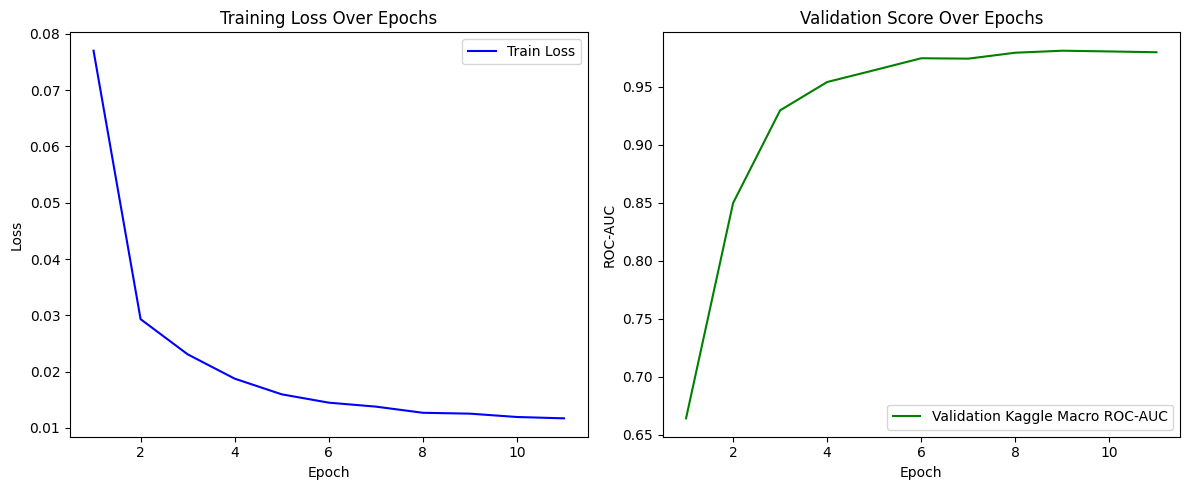

In [21]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12,5))

    # Train loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    # Validation Kaggle Macro ROC-AUC plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_score'], 'g-', label='Validation Kaggle Macro ROC-AUC')
    plt.xlabel('Epoch')
    plt.ylabel('ROC-AUC')
    plt.title('Validation Score Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Use this after training:
plot_training_history(history)


---
### Next Steps: Phase 2 Training

To further improve the model, proceed with **Phase 2 training**, which incorporates advanced fine-tuning techniques and potentially additional data augmentation strategies.

Explore the detailed Phase 2 training notebook here:  
[BirdCLEF 2025 Model Training Phase 2](https://www.kaggle.com/code/sheemamasood/birdclef2025-model-training-phase2)  
- This phase includes self-supervised learning using pseudo-labeling to boost performance.
-------------

## for debugging

In [22]:
# ===================== MODEL =====================
class ImprovedBirdCLEFModel(nn.Module):
    def __init__(self, num_classes=187, backbone_weights=None, device=device):
        super().__init__()
        self.backbone = timm.create_model(
            "seresnext26t_32x4d",
            pretrained=False,
            in_chans=3,
            num_classes=0
        )
        if backbone_weights:
            state_dict = torch.load(backbone_weights, map_location=device)
            self.backbone.load_state_dict(state_dict, strict=False)
        self.classifier = nn.Sequential(
            nn.Linear(self.backbone.num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

def load_model(model_path, device, num_classes, backbone_weights):
    model = ImprovedBirdCLEFModel(num_classes=num_classes, backbone_weights=backbone_weights, device=device)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()
    return model
    
model = load_model(
    model_path=config.model_path,
    device=device,
    num_classes=187,
    backbone_weights=config.backbone_weights  # Pass it as a keyword argument
)
print("✅ Model loaded!")


✅ Model loaded!


In [23]:
# Validate model on validation dataloader
val_score = validate_model(model, val_loader, device, kaggle_macro_roc_auc_ignoring_empty)
print(f"📊 Validation Macro ROC-AUC: {val_score:.4f}")

📊 Validation Macro ROC-AUC: 0.9857


In [24]:
def debug_validate_model(model, dataloader, device, species_ids, num_batches=1):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            if batch_idx >= num_batches:
                break

            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.cpu().numpy()

            outputs = model(inputs)
            preds = torch.sigmoid(outputs).cpu().numpy()

            all_preds.append(preds)
            all_targets.append(targets)

            # 🖨️ Print predictions
            for i in range(len(preds)):
                top5_idx = preds[i].argsort()[-5:][::-1]  # Top 5 predictions
                top5_probs = preds[i][top5_idx]
                true_indices = np.where(targets[i] == 1)[0]

                print(f"\n🔊 Sample {i+1}:")
                print(f"✅ True Labels: {[species_ids[j] for j in true_indices]}")
                print(f"🔮 Top Predictions:")
                for rank, (cls_idx, prob) in enumerate(zip(top5_idx, top5_probs), start=1):
                    print(f"  {rank}. {species_ids[cls_idx]} ({prob:.3f})")

    return


debug_validate_model(
    model=model,
    dataloader=val_loader,
    device=device,
    species_ids=species_ids,  # a list like ['species_1', ..., 'species_187']
    num_batches=2  # check first 2 batches only
)



🔊 Sample 1:
✅ True Labels: ['21211']
🔮 Top Predictions:
  1. 21211 (0.902)
  2. 24292 (0.046)
  3. 66893 (0.017)
  4. 65336 (0.013)
  5. 42113 (0.007)

🔊 Sample 2:
✅ True Labels: ['65344']
🔮 Top Predictions:
  1. 65344 (0.908)
  2. 21038 (0.009)
  3. 41970 (0.005)
  4. 476537 (0.004)
  5. blbgra1 (0.004)

🔊 Sample 3:
✅ True Labels: ['24292']
🔮 Top Predictions:
  1. 24292 (0.999)
  2. 1462711 (0.231)
  3. 66893 (0.011)
  4. 1139490 (0.000)
  5. 66578 (0.000)

🔊 Sample 4:
✅ True Labels: ['64862']
🔮 Top Predictions:
  1. 65336 (0.850)
  2. 64862 (0.072)
  3. 24292 (0.040)
  4. 715170 (0.024)
  5. 42007 (0.012)

🔊 Sample 5:
✅ True Labels: ['555086']
🔮 Top Predictions:
  1. 555086 (0.947)
  2. 65344 (0.011)
  3. cinbec1 (0.004)
  4. rutpuf1 (0.003)
  5. bicwre1 (0.003)

🔊 Sample 6:
✅ True Labels: ['royfly1']
🔮 Top Predictions:
  1. royfly1 (0.851)
  2. cocwoo1 (0.011)
  3. rutpuf1 (0.010)
  4. bubcur1 (0.007)
  5. banana (0.005)

🔊 Sample 7:
✅ True Labels: ['1192948']
🔮 Top Predictions:
  